# (29) DOVES — LinearPoisson — 0

**Motivation**: Reproduce a result from 23rd. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Import $/$ prep

In [2]:
from _tmp.linvae import prepare_stuff
from _tmp.gapvae import iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

In [3]:
n_latents = 512

dim = 16
bias = False

batch_size = 1000
epochs = 3600

lvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    device_idx=0,
    poisson=True,
    dim=dim,
    bias=bias,
    n_latents=n_latents,
    max_grad_norm=5000, # 500,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+------------------+------------+
|   Module Name    | Num Params |
+------------------+------------+
| LinearPoissonVAE |  262.7 K   |
|       ---        |    ---     |
|       enc        |  131.1 K   |
|       dec        |  131.1 K   |
+------------------+------------+

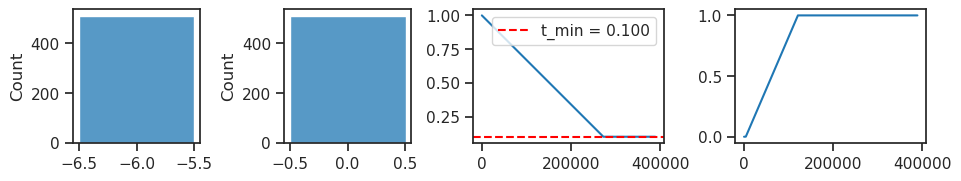

In [4]:
fig, axes = create_figure(1, 4, (9.5, 1.7), width_ratios=[1, 1, 1.5, 1.5], layout='constrained')

sns.histplot(to_np(lvae.log_rates).ravel(), ax=axes[0])
sns.histplot(to_np(lvae.log_rates.exp()).ravel(), ax=axes[1])
axes[2].plot(kws_iter['temperatures'])
axes[3].plot(kws_iter['beta_values'])
_t = kws_iter['temperatures'].min()
axes[2].axhline(_t, color='r', ls='--', label=f't_min = {_t:0.3f}')
axes[2].legend()
plt.show()

In [5]:
lvae.log_rates.detach().exp().min(), lvae.log_rates.detach().exp().max()

(tensor(0.0025, device='cuda:0'), tensor(0.0025, device='cuda:0'))

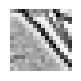

In [6]:
fig, ax = create_figure(1, 1, (1.0, 0.8))
ax.imshow(to_np(vld.dataset.x[1400, 0]), cmap='Greys_r')
remove_ticks(ax)
plt.show()

## Train / Validate

### trn

In [7]:
%%time

pbar = tqdm(range(epochs), ncols=130, position=0)
nelbo, grads = np.zeros(epochs), np.zeros(epochs)

for ep in pbar:
    grad, tot, recon, kl, r99 = iteration(
        ep, lvae, trn, optim, optim_schedule, device, **kws_iter)
    nelbo[ep], grads[ep] = recon + 1.0 * kl, grad

    msg = ',  '.join([
        f"grad = {grad:0.1f}",
        f"r99 = {r99:0.1f}",
        f"loss = (kl: {kl:0.1f}, recon: {recon:0.1f}  ——  tot: {tot:0.2f})  ",
    ])
    pbar.set_description(msg)

grad = 39.4,  r99 = 10.6,  loss = (kl: 33.6, recon: 133.0  ——  tot: 166.62)  : 100%|██████████| 3600/3600 [59:39<00:00,  1.01it/s]

CPU times: user 7h 11min 37s, sys: 8min, total: 7h 19min 38s
Wall time: 59min 39s


In [8]:
loss_vld = validate(lvae, vld, device)
loss_vld

{'kl': 30.25805962804034,
 'recon': 135.27748415370996,
 'tot': 165.53554384909947}

## Plot weights

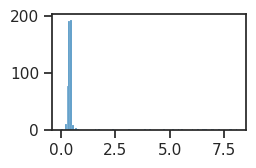

In [10]:
rates = to_np(lvae.log_rates.exp()).ravel()

fig, ax = create_figure(1, 1, (2.5, 1.5))
sns.histplot(rates, bins=100, ax=ax)
ax.set_ylabel('')
plt.show()

In [11]:
w_dec = lvae.dec.weight.T.reshape(
    n_latents, 1, dim, dim)
w_dec = to_np(w_dec[np.argsort(rates)])
grid_dec = make_grid(w_dec, (16, 32))

w_dec.shape, grid_dec.shape

((512, 1, 16, 16), (271, 543))

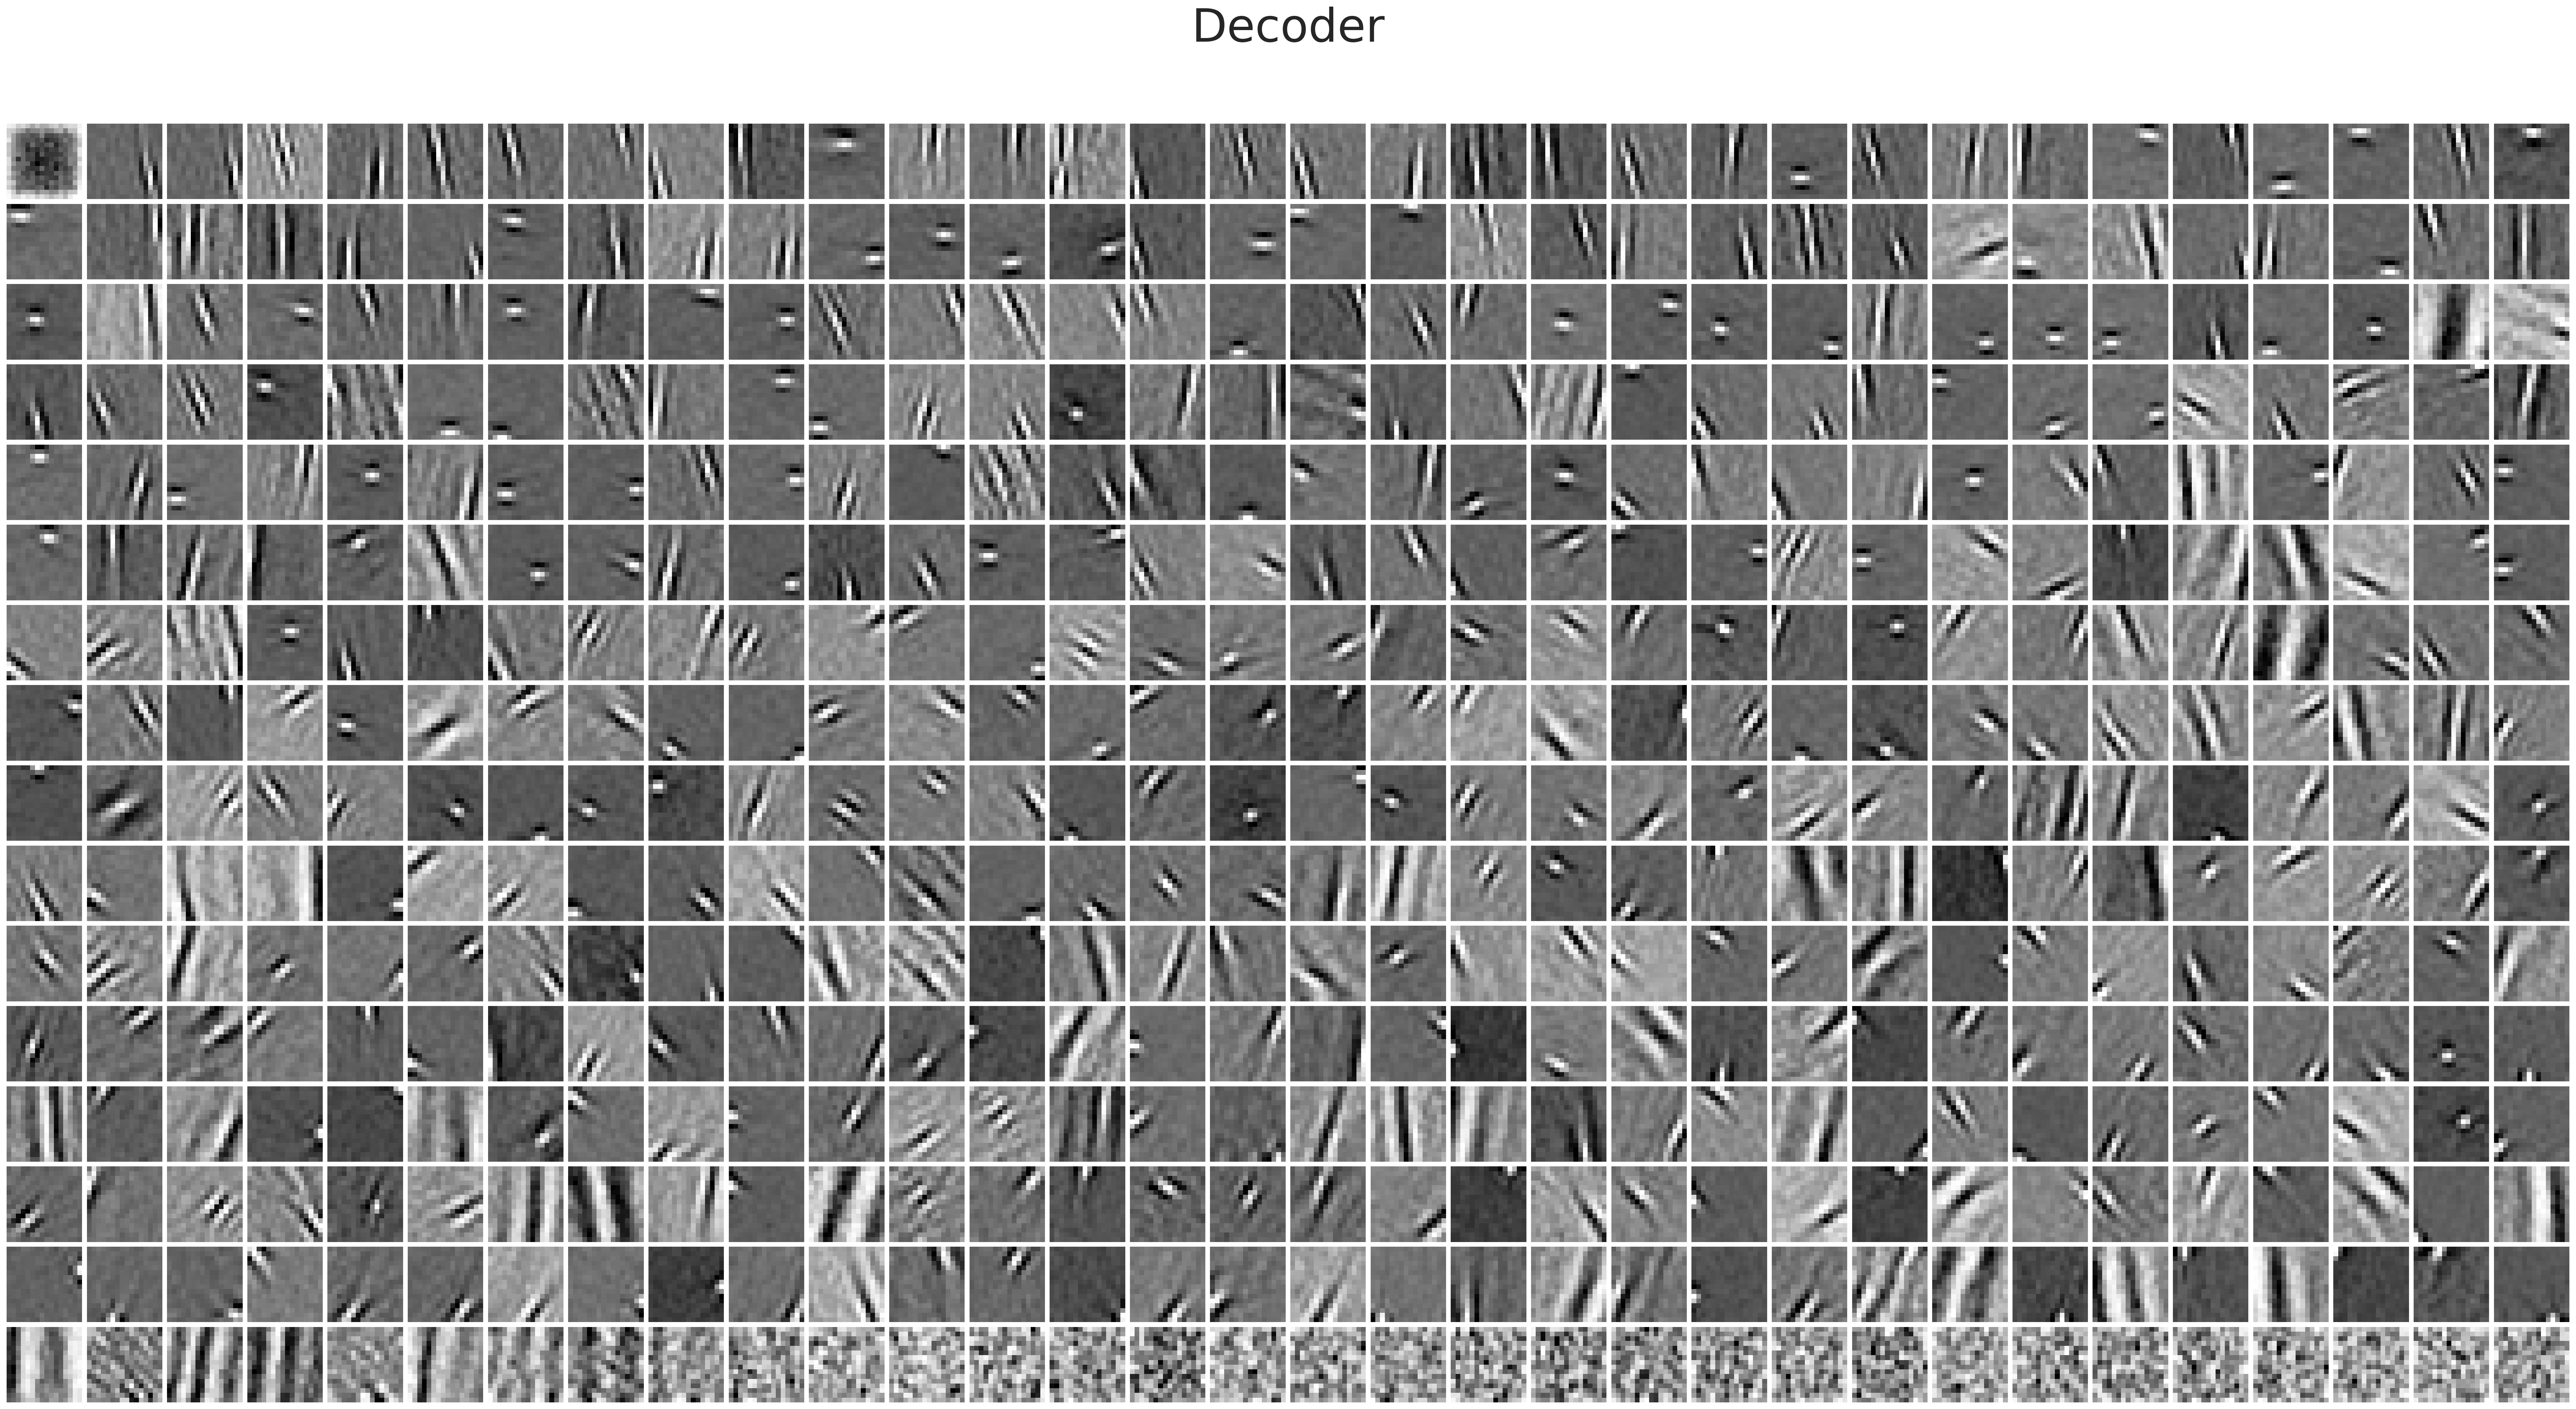

In [12]:
fig, ax = create_figure(1, 1, (50, 26), dpi=200)
ax.imshow(grid_dec, cmap='Greys_r')
ax.set_title('Decoder', fontsize=50, y=1.06)
remove_ticks(ax)
plt.show()

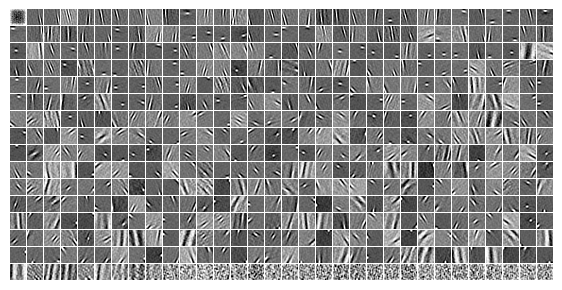

In [14]:
fig, ax = create_figure(1, 1, (7, 5.5), dpi=100)
ax.imshow(grid_dec, cmap='Greys_r')
remove_ticks(ax)
plt.show()

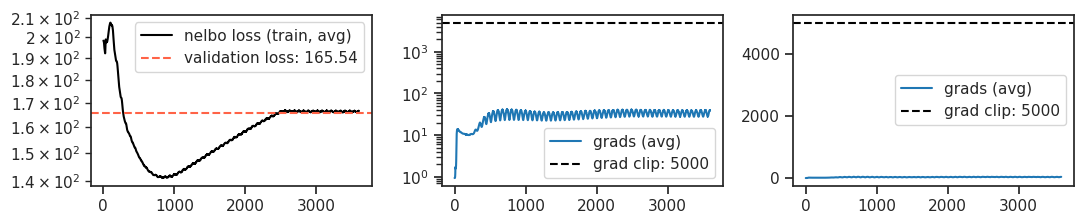

In [15]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(nelbo, color='k', label='nelbo loss (train, avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(kws_iter['max_grad_norm'], color='k', ls='--', label=f"grad clip: {kws_iter['max_grad_norm']}")
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
# axes[0].set_ylim(top=50)
plt.show()

In [16]:
lvae.temp = 0.0

In [17]:
spks, r_q, r_qp = [], [], []

for x in iter(vld):
    with torch.inference_mode():
        out = lvae(x.to(device))
    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['log_dr'].exp()))
    r_qp.append(to_np(torch.exp(out['log_r'] + out['log_dr'])))

spks, r_q, r_qp = cat_map([spks, r_q, r_qp])
spks = spks.astype(int)

In [18]:
np.quantile(spks.ravel(), 1.0)

27.0

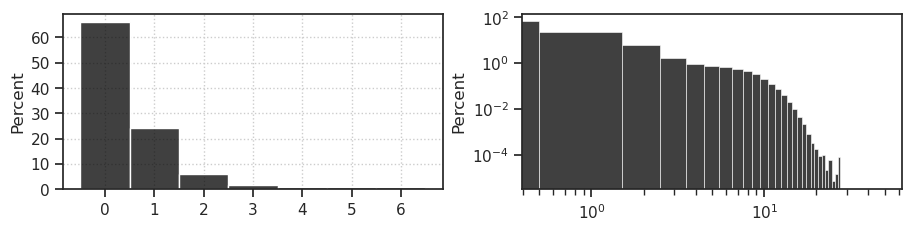

In [19]:
fig, axes = create_figure(1, 2, (9, 2.2), layout='constrained')

nbins = 7
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[0])
nbins = 50
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[1])

axes[0].locator_params(axis='y', nbins=10)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].grid()

plt.show()

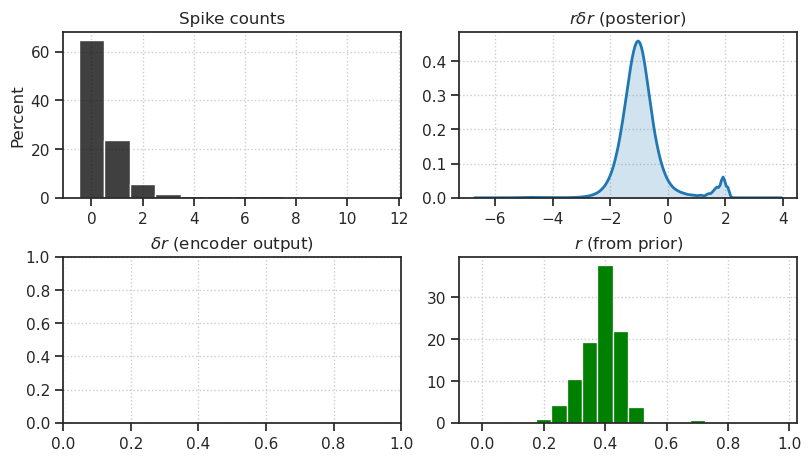

In [20]:
fig, axes = create_figure(2, 2, (8, 4.5), layout='constrained')

nbins = 12
_kws = dict(
    legend=False, 
    stat='percent',
    bins=np.linspace(0, nbins, nbins+1) - 0.5,
    color='k',
)
sns.histplot(spks.ravel(),  ax=axes[0, 0], **_kws)
# axes[0, 0].locator_params(axis='x', nbins=nbins+2)

_kws = dict(
    kde=True,
    legend=False, 
    stat='percent',
    line_kws={'lw': 2},
    alpha=0.2,
)
# sns.histplot(r_q.ravel(), ax=axes[1, 0], **_kws)
sns.histplot(np.log(r_qp.ravel()),  ax=axes[0, 1], **_kws)
_kws.update(dict(kde=False, alpha=1.0, color='g', bins=np.linspace(0, 1, 21) - 0.025))
sns.histplot(to_np(lvae.log_rates.exp()).ravel(), ax=axes[1, 1], **_kws)

axes[0, 0].set_title('Spike counts')
axes[0, 1].set_title(r'$r \delta r$' + ' (posterior)')

axes[1, 0].set_title(r'$\delta r$' + ' (encoder output)')
axes[1, 1].set_title(r'$r$' + ' (from prior)')

# axes[1, 0].set_ylim(top=350)

for ax in axes[:, 1]:
    ax.set_ylabel('')

add_grid(axes)

plt.show()

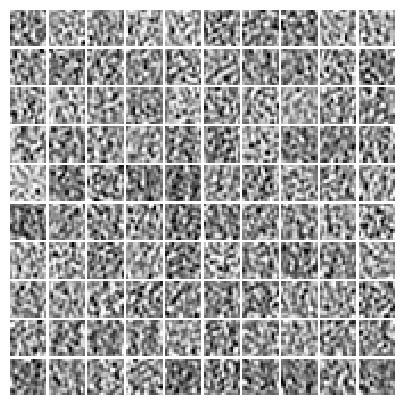

In [21]:
t = 0.0
x_samples = lvae.sample(100, t)
grid = make_grid(x_samples, grid_size=10)

fig, ax = create_figure(1, 1, (5, 5))
ax.imshow(grid, cmap='Greys_r')
remove_ticks(ax)
plt.show()

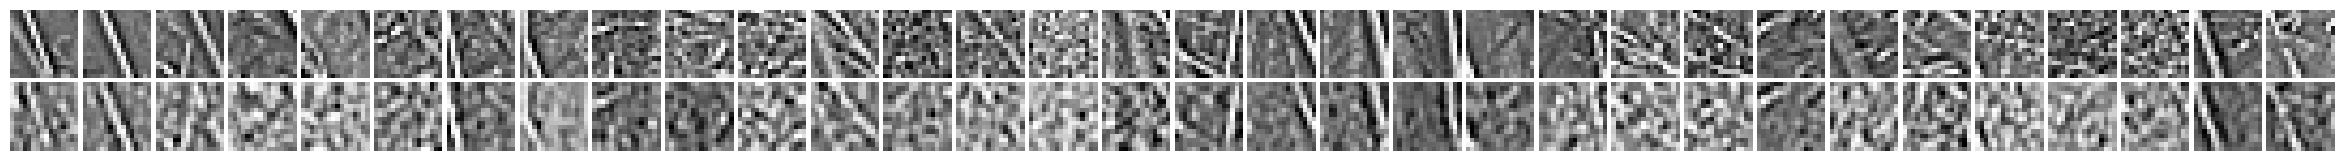

In [22]:
x = vld.dataset.x[1000:1100]
with torch.inference_mode():
    out = lvae(x)

num = 32
grid = make_grid(
    torch.cat([x[:num], out['x_recon'][:num]]),
    grid_size=(2, 32),
)

fig, ax = create_figure(1, 1, (30, 10))
ax.imshow(grid, cmap='Greys_r')
remove_ticks(ax)
plt.show()